In [83]:
## import libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
%matplotlib inline
import re
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import RFE
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
import plotly.express as px
import warnings
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.impute import SimpleImputer
import mlflow
from mlflow.models import infer_signature
from sklearn.mixture import GaussianMixture

In [84]:
warnings.filterwarnings('ignore')

In [85]:
## Getting train data

data = pd.read_csv('train_car.csv')

In [86]:
data.head()

,ID,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Segmentation
0,462809,Male,No,22,No,Healthcare,1.0,Low,4.0,Cat_4,D
1,462643,Female,Yes,38,Yes,Engineer,NaN,Average,3.0,Cat_4,A
2,466315,Female,Yes,67,Yes,Engineer,1.0,Low,1.0,Cat_6,B
3,461735,Male,Yes,67,Yes,Lawyer,0.0,High,2.0,Cat_6,B
4,462669,Female,Yes,40,Yes,Entertainment,NaN,High,6.0,Cat_6,A


DATA PREPROCESSING

In [87]:
print(data.dtypes)

ID                   int64
Gender              object
Ever_Married        object
Age                  int64
Graduated           object
Profession          object
Work_Experience    float64
Spending_Score      object
Family_Size        float64
Var_1               object
Segmentation        object
dtype: object


In [88]:
print(data.describe())

                  ID          Age  Work_Experience  Family_Size
count    8068.000000  8068.000000      7239.000000  7733.000000
mean   463479.214551    43.466906         2.641663     2.850123
std      2595.381232    16.711696         3.406763     1.531413
min    458982.000000    18.000000         0.000000     1.000000
25%    461240.750000    30.000000         0.000000     2.000000
50%    463472.500000    40.000000         1.000000     3.000000
75%    465744.250000    53.000000         4.000000     4.000000
max    467974.000000    89.000000        14.000000     9.000000


In [89]:
print(data.isnull().sum())

ID                   0
Gender               0
Ever_Married       140
Age                  0
Graduated           78
Profession         124
Work_Experience    829
Spending_Score       0
Family_Size        335
Var_1               76
Segmentation         0
dtype: int64


In [90]:
## To identify rows in the DataFrame where at least one value is missing (NaN/null) across any column
data[data.isnull().any(axis = 1)]

,ID,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Segmentation
1,462643,Female,Yes,38,Yes,Engineer,NaN,Average,3.0,Cat_4,A
4,462669,Female,Yes,40,Yes,Entertainment,NaN,High,6.0,Cat_6,A
12,461230,Female,No,19,No,Executive,0.0,Low,NaN,Cat_3,D
13,459573,Male,Yes,70,No,Lawyer,NaN,Low,1.0,Cat_6,A
24,461021,Female,NaN,58,No,Executive,1.0,Average,3.0,Cat_3,B
...,...,...,...,...,...,...,...,...,...,...,...
8040,467165,Female,No,25,No,Homemaker,NaN,Low,1.0,Cat_6,D
8044,466997,Female,NaN,50,No,Engineer,1.0,Low,2.0,Cat_6,D
8047,462396,Male,Yes,50,Yes,Doctor,NaN,Average,2.0,Cat_6,C
8049,461292,Female,Yes,81,No,Lawyer,NaN,High,2.0,Cat_3,D


In [91]:
# Handle missing values for categorical variables
#Ever_Married, Graduated, Profession, and Var_1:
#These columns are categorical variables. One approach is to fill the missing values with the mode (most frequent value) of each respective column since they are categorical variables.
#This can be done using the fillna() method with the mode() function.


data['Ever_Married'].fillna(data['Ever_Married'].mode()[0], inplace=True)
data['Graduated'].fillna(data['Graduated'].mode()[0], inplace=True)
data['Profession'].fillna(data['Profession'].mode()[0], inplace=True)
data['Var_1'].fillna(data['Var_1'].mode()[0], inplace=True)

In [92]:
# Handle missing values for numerical variables
#Work_Experience, Family_Size:
#These columns are numerical variables. One common approach is to fill the missing values with the median of each respective column since it is less sensitive to outliers compared to the mean

data['Work_Experience'].fillna(data['Work_Experience'].median(), inplace=True)
data['Family_Size'].fillna(data['Family_Size'].median(), inplace=True)

In [93]:
# Check if missing values are handled
print(data.isnull().sum())

ID                 0
Gender             0
Ever_Married       0
Age                0
Graduated          0
Profession         0
Work_Experience    0
Spending_Score     0
Family_Size        0
Var_1              0
Segmentation       0
dtype: int64


ENCODING

In [94]:


# Drop ID column as it is not informative for clustering
data = data.drop(['ID','Segmentation'], axis=1)

# Identify categorical and numerical columns
categorical_cols = ['Gender', 'Ever_Married', 'Graduated', 'Profession', 'Spending_Score', 'Var_1']
numerical_cols = ['Age', 'Work_Experience', 'Family_Size']

# Define preprocessing steps
categorical_transformer = OneHotEncoder(handle_unknown='ignore')
numerical_transformer = StandardScaler()

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_cols),
        ('num', numerical_transformer, numerical_cols)
    ])

# Fit and transform the data
processed_data = preprocessor.fit_transform(data)

# Check the shape of the processed data
print("Shape of processed data:", processed_data.shape)


Shape of processed data: (8068, 28)


CLUSTERING

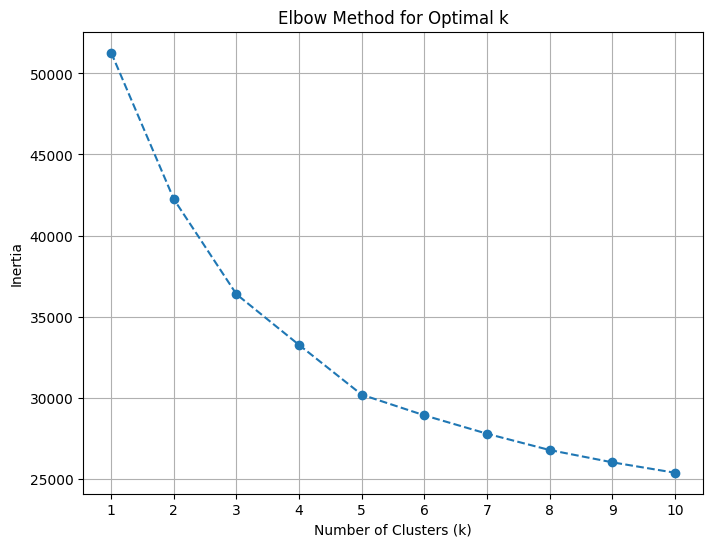

In [95]:
## Deciding on the K value using Elbow method

# Fit KMeans models with different values of k
inertia_values = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(processed_data)
    inertia_values.append(kmeans.inertia_)

# Plot the Elbow curve
plt.figure(figsize=(8, 6))
plt.plot(range(1, 11), inertia_values, marker='o', linestyle='--')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.xticks(range(1, 11))
plt.grid(True)
plt.show()


K Means

In [96]:
# Instantiate clustering models
kmeans = KMeans(n_clusters=3, random_state=42)

# Fit models to the training data
kmeans.fit(processed_data)

# Predict clusters for training and test data
train_kmeans_clusters = kmeans.predict(processed_data)
test_kmeans_clusters = kmeans.predict(processed_data)

# Calculate evaluation metrics for K-means
kmeans_silhouette_score = silhouette_score(processed_data, train_kmeans_clusters)
kmeans_davies_bouldin_score = davies_bouldin_score(processed_data, train_kmeans_clusters)

# Print evaluation metrics
print("K-means Silhouette Score:", kmeans_silhouette_score)
print("K-means Davies-Bouldin Score:", kmeans_davies_bouldin_score)


K-means Silhouette Score: 0.19405388033121296
K-means Davies-Bouldin Score: 1.7355005926722127


HIERARICAL

In [97]:
# Instantiate clustering models
hierarchical = AgglomerativeClustering(n_clusters=5)

# Fit models to the training data
hierarchical.fit(processed_data)

# Predict clusters for training and test data
train_hierarchical_clusters = hierarchical.labels_

# Calculate evaluation metrics for Hierarchical Clustering
hierarchical_silhouette_score = silhouette_score(processed_data, train_hierarchical_clusters)
hierarchical_davies_bouldin_score = davies_bouldin_score(processed_data, train_hierarchical_clusters)

print("Hierarchical Clustering Silhouette Score:", hierarchical_silhouette_score)
print("Hierarchical Clustering Davies-Bouldin Score:", hierarchical_davies_bouldin_score)

Hierarchical Clustering Silhouette Score: 0.13343949338020722
Hierarchical Clustering Davies-Bouldin Score: 1.9019644159898097


DBSCAN

In [98]:
# Instantiate clustering models
dbscan = DBSCAN(eps=0.5, min_samples=5)

# Fit models to the training data
dbscan.fit(processed_data)

# Predict clusters for training and test data
train_dbscan_clusters = dbscan.labels_

# Calculate evaluation metrics for DBSCAN
dbscan_silhouette_score = silhouette_score(processed_data, train_dbscan_clusters)
# Davies-Bouldin index is not applicable for DBSCAN

print("DBSCAN Silhouette Score:", dbscan_silhouette_score)
print("DBSCAN Davies-Bouldin Score: Not applicable")


DBSCAN Silhouette Score: -0.1411978377934359
DBSCAN Davies-Bouldin Score: Not applicable


GaussianMixture

In [99]:
# Instantiate clustering models
gmm = GaussianMixture(n_components=5, random_state=42)

# Fit models to the training data
gmm.fit(processed_data)

# Predict clusters for training and test data
train_gmm_clusters = gmm.predict(processed_data)

# Calculate evaluation metrics for GMM
gmm_silhouette_score = silhouette_score(processed_data, train_gmm_clusters)
gmm_davies_bouldin_score = davies_bouldin_score(processed_data, train_gmm_clusters)

print("GMM Silhouette Score:", gmm_silhouette_score)
print("GMM Davies-Bouldin Score:", gmm_davies_bouldin_score)

GMM Silhouette Score: 0.034799614572174245
GMM Davies-Bouldin Score: 3.814989054671842


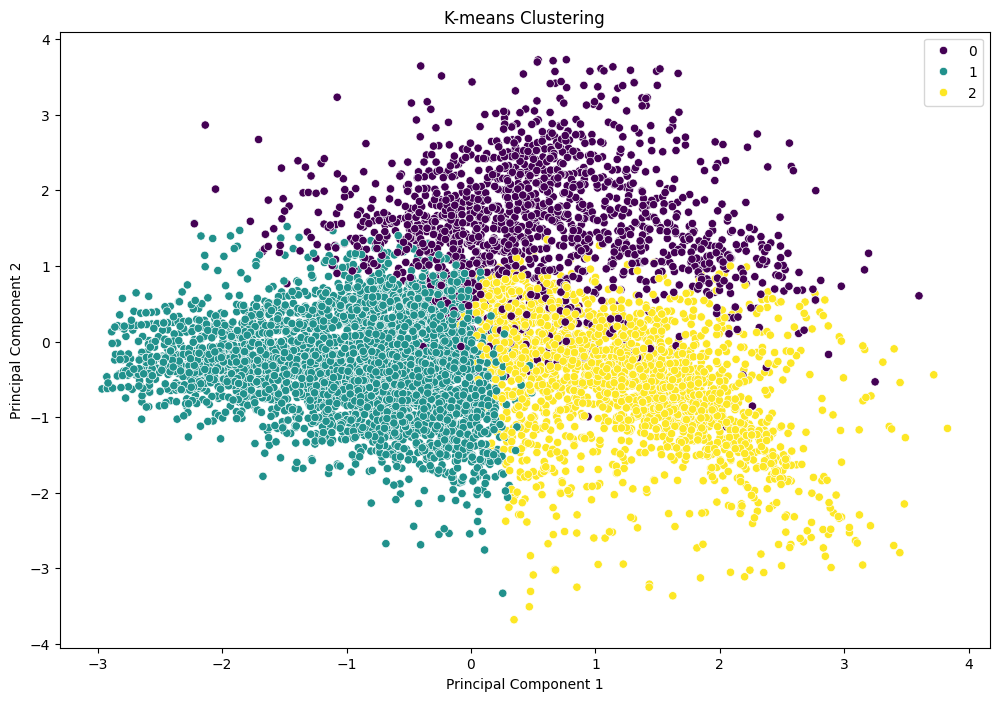

In [100]:
# visualize clusters using PCA
from sklearn.decomposition import PCA

# Reduce dimensionality to 2D using PCA
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(processed_data)

# Plot clusters
plt.figure(figsize=(12, 8))
sns.scatterplot(x=reduced_data[:, 0], y=reduced_data[:, 1], hue=train_kmeans_clusters, palette='viridis', legend='full')
plt.title('K-means Clustering')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

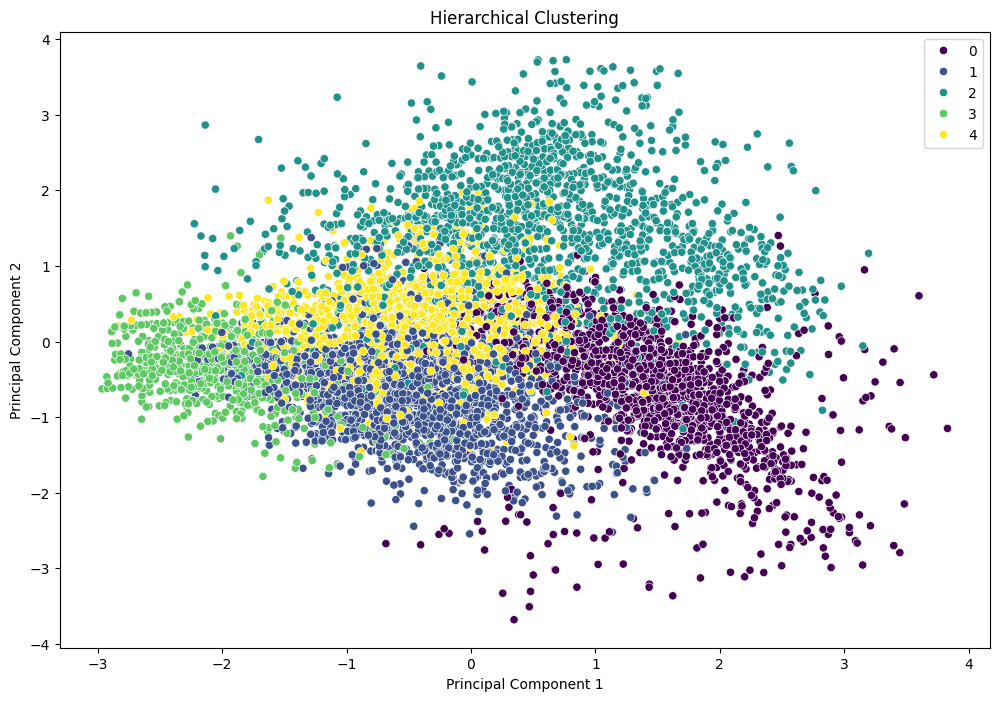

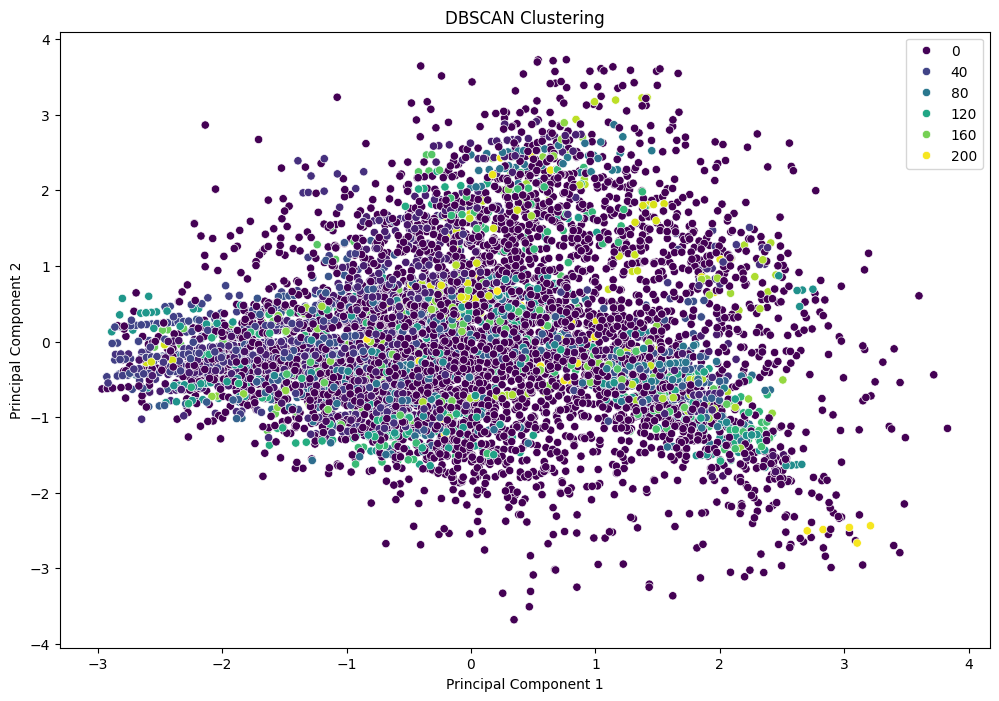

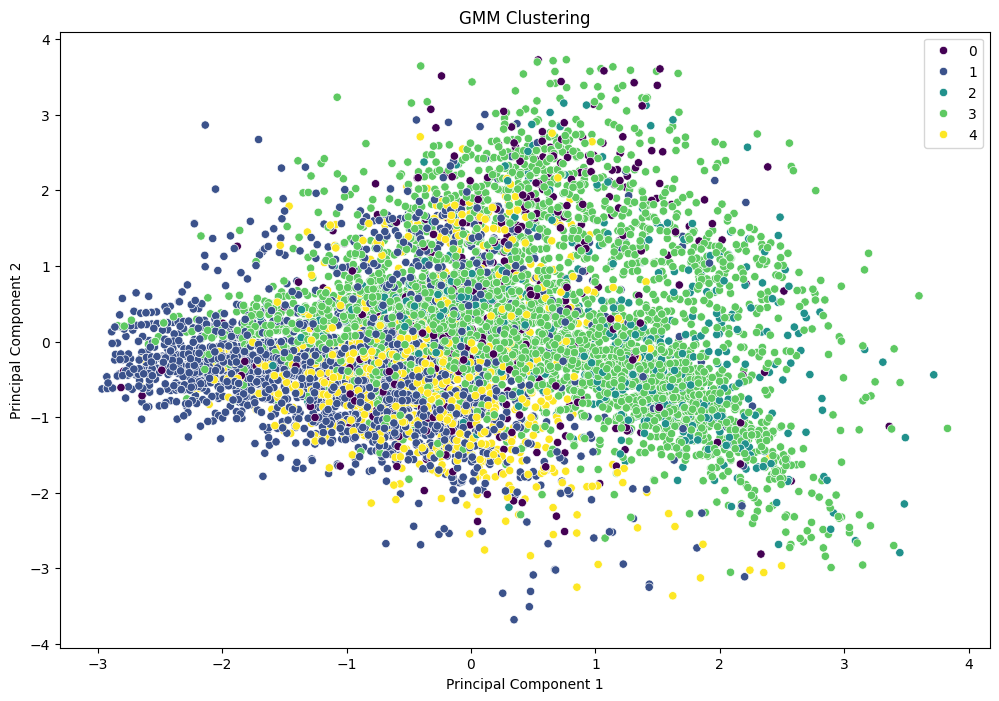

In [101]:
# Visualize clusters using PCA
from sklearn.decomposition import PCA

# Reduce dimensionality to 2D using PCA
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(processed_data)


# Visualize clusters for Hierarchical Clustering
plt.figure(figsize=(12, 8))
sns.scatterplot(x=reduced_data[:, 0], y=reduced_data[:, 1], hue=train_hierarchical_clusters, palette='viridis', legend='full')
plt.title('Hierarchical Clustering')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

# Visualize clusters for DBSCAN
plt.figure(figsize=(12, 8))
sns.scatterplot(x=reduced_data[:, 0], y=reduced_data[:, 1], hue=train_dbscan_clusters, palette='viridis')
plt.title('DBSCAN Clustering')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

# Visualize clusters for GMM
plt.figure(figsize=(12, 8))
sns.scatterplot(x=reduced_data[:, 0], y=reduced_data[:, 1], hue=train_gmm_clusters, palette='viridis', legend='full')
plt.title('GMM Clustering')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()


Predicting New Customer Segments -Kmeans

In [102]:
test_car_data = pd.read_csv('test_car.csv')

In [103]:
test_car_data.head()

,ID,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1
0,458989,Female,Yes,36,Yes,Engineer,0.0,Low,1.0,Cat_6
1,458994,Male,Yes,37,Yes,Healthcare,8.0,Average,4.0,Cat_6
2,458996,Female,Yes,69,No,NaN,0.0,Low,1.0,Cat_6
3,459000,Male,Yes,59,No,Executive,11.0,High,2.0,Cat_6
4,459001,Female,No,19,No,Marketing,NaN,Low,4.0,Cat_6


In [104]:
print(test_car_data.dtypes)

ID                   int64
Gender              object
Ever_Married        object
Age                  int64
Graduated           object
Profession          object
Work_Experience    float64
Spending_Score      object
Family_Size        float64
Var_1               object
dtype: object


In [105]:
## To identify rows in the DataFrame where at least one value is missing (NaN/null) across any column
print(test_car_data.isnull().sum())

ID                   0
Gender               0
Ever_Married        50
Age                  0
Graduated           24
Profession          38
Work_Experience    269
Spending_Score       0
Family_Size        113
Var_1               32
dtype: int64


In [106]:
test_car_data[test_car_data.isnull().any(axis = 1)]

,ID,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1
2,458996,Female,Yes,69,No,NaN,0.0,Low,1.0,Cat_6
4,459001,Female,No,19,No,Marketing,NaN,Low,4.0,Cat_6
20,459056,Male,Yes,63,No,Executive,NaN,High,3.0,Cat_6
21,459057,Male,Yes,69,No,Lawyer,NaN,High,NaN,Cat_6
23,459059,Male,Yes,79,No,Executive,NaN,High,2.0,Cat_6
...,...,...,...,...,...,...,...,...,...,...
2547,467706,Female,Yes,35,Yes,Artist,NaN,Average,4.0,Cat_6
2572,467798,Female,No,23,No,NaN,NaN,Low,2.0,Cat_6
2588,467861,Female,No,29,No,Artist,NaN,Low,4.0,Cat_4
2593,467879,Female,Yes,51,Yes,Artist,NaN,High,4.0,Cat_6


In [107]:
# Remove the ID column
test_car_data.drop('ID', axis=1, inplace=True)

In [108]:
# Handle missing values for categorical variables
#Ever_Married, Graduated, Profession, and Var_1:
#These columns are categorical variables. One approach is to fill the missing values with the mode (most frequent value) of each respective column since they are categorical variables.
#This can be done using the fillna() method with the mode() function.


test_car_data['Ever_Married'].fillna(test_car_data['Ever_Married'].mode()[0], inplace=True)
test_car_data['Graduated'].fillna(test_car_data['Graduated'].mode()[0], inplace=True)
test_car_data['Profession'].fillna(test_car_data['Profession'].mode()[0], inplace=True)
test_car_data['Var_1'].fillna(test_car_data['Var_1'].mode()[0], inplace=True)

In [109]:
# Handle missing values for numerical variables
#Work_Experience, Family_Size:
#These columns are numerical variables. One common approach is to fill the missing values with the median of each respective column since it is less sensitive to outliers compared to the mean

test_car_data['Work_Experience'].fillna(test_car_data['Work_Experience'].median(), inplace=True)
test_car_data['Family_Size'].fillna(test_car_data['Family_Size'].median(), inplace=True)

In [110]:
# Check if missing values are handled
print(test_car_data.isnull().sum())

Gender             0
Ever_Married       0
Age                0
Graduated          0
Profession         0
Work_Experience    0
Spending_Score     0
Family_Size        0
Var_1              0
dtype: int64


In [111]:
# Scale numerical features 'Age', 'Work_Experience', 'Family_Size'
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

test_car_data[['Age', 'Work_Experience', 'Family_Size']] = scaler.fit_transform(test_car_data[['Age', 'Work_Experience', 'Family_Size']])

In [112]:
# Fit and transform the test data using the preprocessor defined earlier
processed_test_data = preprocessor.transform(test_car_data)

# Check the shape of the processed test data
print("Shape of processed test data:", processed_test_data.shape)

Shape of processed test data: (2627, 28)


In [113]:
# Predict cluster labels for new potential customers
new_customer_labels = kmeans.predict(processed_test_data)


In [114]:
# Calculate the silhouette score
silhouette_score_kmeans_test = silhouette_score(processed_test_data, new_customer_labels)

print("Silhouette Score: ", silhouette_score_kmeans_test)

Silhouette Score:  -0.025616504046563685
